In [1]:
import torch, pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter, FuncFormatter
from math import sin,cos,sqrt
folder = '/home/dgotzens/shares/messdaten/000_Products/iMCR/2024-04-25_Channel-Antenna-Gain_LD_dgs/'
pi = torch.pi

In [2]:
data = torch.stack(torch.load(folder+'hcr-3m_data.pt'),-1)
angle = pickle.load(open(folder+'hcr-3m_angle.pkl', 'rb'))
M,K,L = data.shape
data *= torch.load(folder+'hcs-3m_calib.pt')[:,:,None]


## Channel Amplitude Characteristik

In [3]:
window = torch.hann_window(M)
window /= window.sum()
dist = 3
R_max = 50
N = 2**13
n_min = int((dist-0.5)/R_max*N)
n_max = int((dist+0.5)/R_max*N)

print(n_min,n_max)


409 573


In [4]:
ant_gain = torch.empty(K,L, dtype=torch.cfloat)

for l in range(L):
    fft = torch.fft.fft(window[:,None]*data[:,:,l], dim=0, n=N)
    n_refl = n_min + fft[n_min:n_max,:].abs().argmax(0)
    ant_gain[:,l] = fft[n_refl,range(K)]

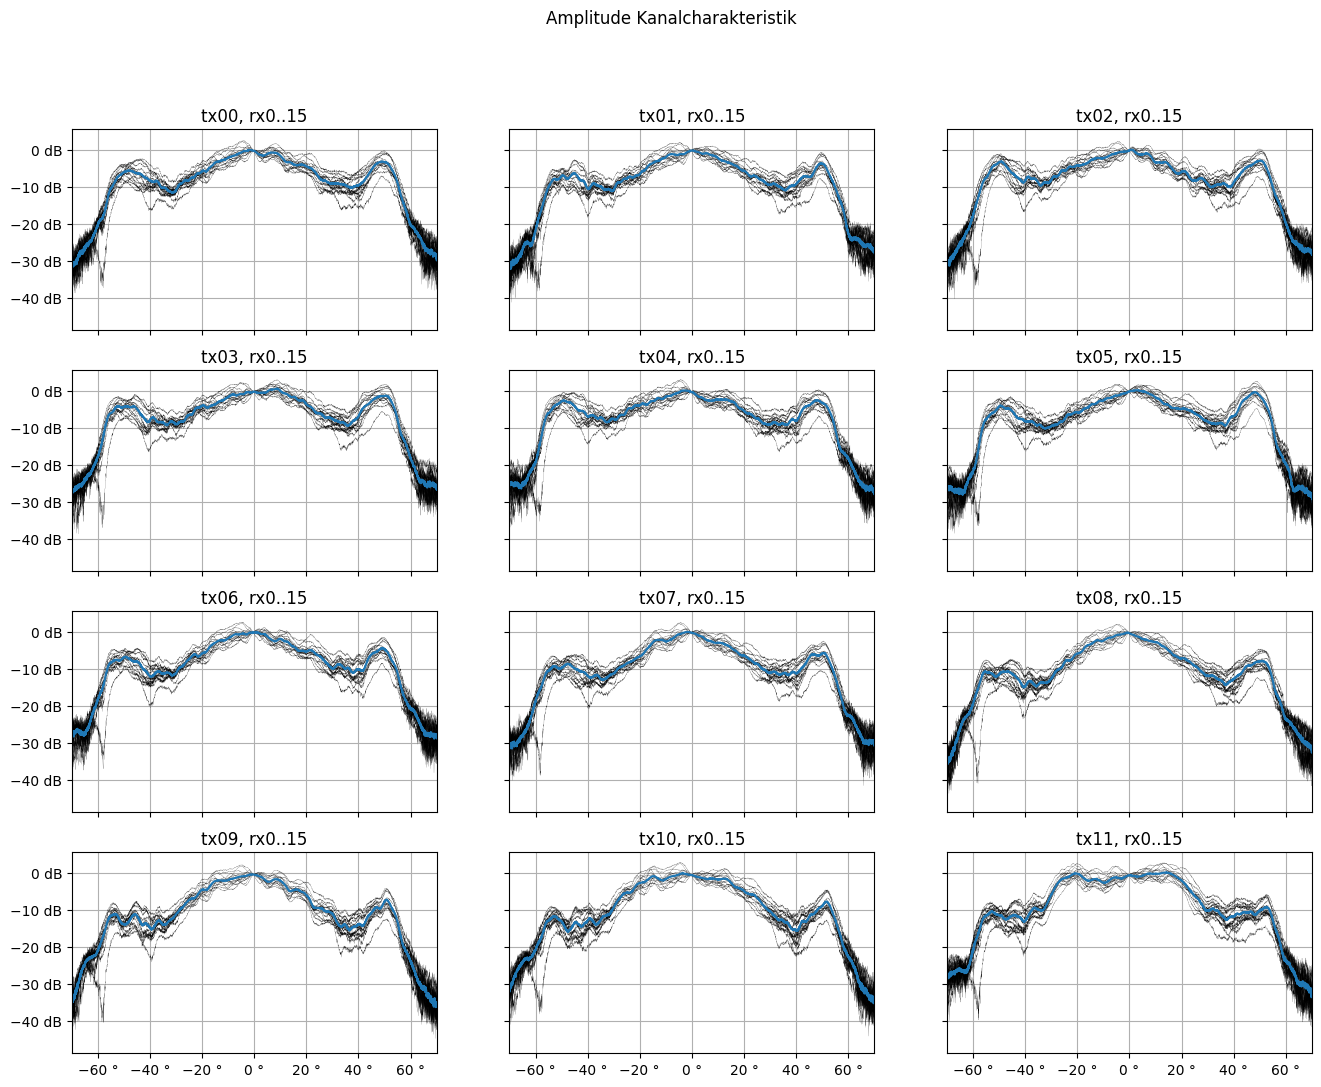

In [7]:
deg = torch.tensor(angle)*180/torch.pi-90

fig, axes = plt.subplots(4,3,sharex=True, sharey=True)
fig.set_size_inches(16,12)
fig.suptitle('Amplitude Kanalcharakteristik')
for n, ax in enumerate(axes.flat):
    for k in range(16*n,16*(n+1)):
        ax.plot(deg, 20*(ant_gain[k,:].abs()).log10(), color='k', linewidth=0.1)
    ax.plot(deg, 20*(ant_gain[16*n:16*(n+1),:].abs().mean(0)).log10())
    ax.grid()
    ax.xaxis.set_major_formatter(EngFormatter('°'))
    ax.yaxis.set_major_formatter(EngFormatter('dB'))
    ax.set_xlim(-70,70)
    ax.set_title(f'tx{n:02d}, rx0..15')


## Reflector Distance Estimation
### Amplitude based

In [518]:
folder = '/home/dgotzens/localstorage/workspace/masterarbeit/thesis/figures/scripts/2.2_antenna-characteristics/measured/'
params = pickle.load(open(folder+'feparams.pkl', 'rb'))
tx,ty,rx,ry = params['txPosX'], params['txPosY'], params['rxPosX'], params['rxPosY']

K=len(tx)

def r_est(R, theta0, exc, theta, K=192):
    txpos = torch.tensor([tx,ty,[exc]*K])
    rxpos = torch.tensor([rx,ry,[exc]*K])
    reflpos = (R+exc)*torch.stack([-torch.sin(theta-theta0),\
                            torch.zeros(len(theta)), \
                            torch.cos(theta-theta0)],0)

    return 0.5*torch.sqrt(((txpos[:,:,None]-reflpos[:,None,:])**2).sum(0))\
          + 0.5*torch.sqrt(((rxpos[:,:,None]-reflpos[:,None,:])**2).sum(0))

def range_estimation_mse(params, r_peak, angle):
    R = (params * torch.tensor([1,0,0])).sum()
    theta0 = (params * torch.tensor([0,1,0])).sum()
    exc = (params * torch.tensor([0,0,1])).sum()
    return torch.mean((r_peak-r_est(R,theta0,exc,torch.tensor(angle)))**2)

def minimize(function, initial_parameters, args):
    list_params = []
    params = initial_parameters
    params.requires_grad_()
    optimizer = torch.optim.SGD([params],lr=1e-2)

    for i in range(1000):
        optimizer.zero_grad()
        loss = function(params,*args)
        loss.backward()
        optimizer.step()
        # with torch.no_grad():
        #     params[0].clamp_(2.8,3.2)
        #     params[1].clamp_(85/180*pi,95/180*pi)
        #     params[2].clamp_(.1,.2)
        list_params.append(params.detach().clone()) #here

    return params,list_params

In [514]:
N = 2**13
n_min = int((dist-0.5)/R_max*N)
n_max = int((dist+0.5)/R_max*N)
r_peak = torch.zeros((K,L))
for l in range(L):
    print(f'{l/L:.1%}', end='\r')
    fft = torch.fft.fft(window[:,None]*data[:,:,l], n=N, dim=0)
    r_peak[:,l] = R_max/N*(n_min + fft[n_min:n_max,:].abs().argmax(0))

print(r_peak.mean())


tensor(3.0250)


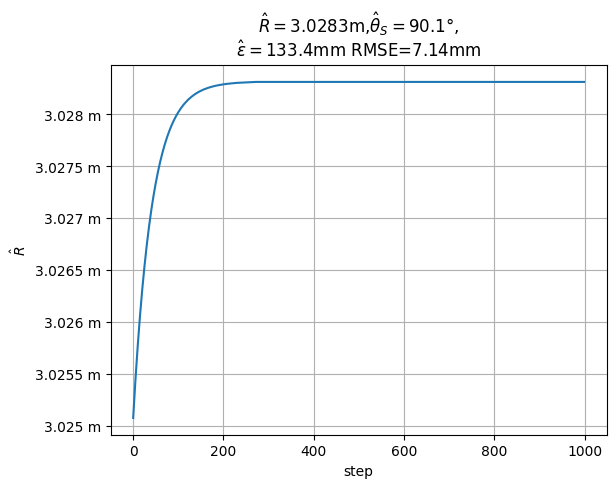

In [520]:
angle_sel = [a for a in angle if -60 < 180/pi*a-90 < 60]
l_sel = [l for l,a in enumerate(angle) if a in angle_sel]
(optdist,optangle,optexc), list_min_dist = minimize(range_estimation_mse, torch.tensor([3.025, pi/2, 0.13]), args=(r_peak[:,l_sel],angle_sel))

from math import sqrt
plt.plot([a[0] for a in list_min_dist])

plt.title(f'$\\hat R={float(optdist):.4f}$m,'+\
f'$\\hat \\theta_S={float(optangle)*180/pi:.1f}$°,'+\
f'\n$\\hat \\epsilon={1000*float(optexc):.1f}$mm '+\
f'RMSE={1000*sqrt(float(range_estimation_mse(list_min_dist[-1],r_peak[:,l_sel],angle_sel))):.2f}mm')
plt.ylabel('$\\hat R$')
plt.xlabel('step')
plt.gca().yaxis.set_major_formatter(EngFormatter('m'))
plt.grid()


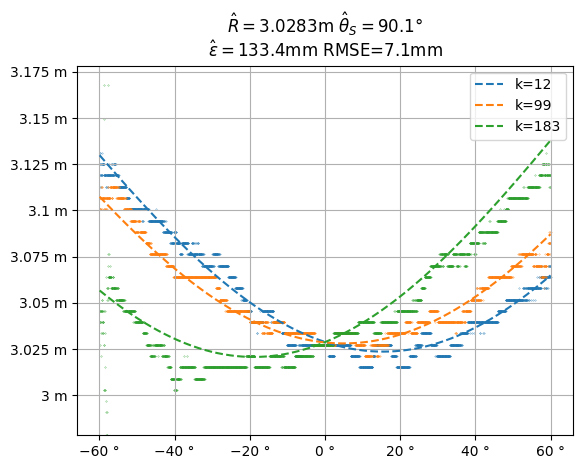

In [530]:
for k in (12,6*16+3,11*16+7):
    plt.scatter([a*180/pi-90 for a in angle_sel], r_peak[k,l_sel], s=0.05)
    plt.plot([a*180/pi-90 for a in angle_sel],\
        r_est(float(optdist),float(optangle),float(optexc),torch.tensor(angle_sel))[k,:], '--', label=f'{k=}')

plt.title(f'$\\hat R={float(optdist):.4f}$m '+\
    f'$\\hat \\theta_S={float(optangle)*180/pi:.1f}$°'+\
    f'\n$\\hat \\epsilon={1000*float(optexc):.1f}$mm '+\
    f'RMSE={1000*sqrt(float(range_estimation_mse(list_min_dist[-1],r_peak[:,l_sel],angle_sel))):.1f}mm')
plt.ylim(float(optdist)-0.05, float(optdist)+0.15)
plt.gca().yaxis.set_major_formatter(EngFormatter('m'))
plt.gca().xaxis.set_major_formatter(EngFormatter('°'))
plt.legend()
plt.grid()



### Phase based

In [531]:
import numpy
f_start=76_009_996_288.0
lightspeed = 299_792_458
R,theta0,exc = float(optdist),float(optangle),float(optexc)

refldist = r_est(R,theta0,exc,torch.tensor(angle))
N_fft = 2**13
n_min = int((dist-0.5)/R_max*N)
n_max = int((dist+0.5)/R_max*N)
window = torch.hann_window(M)
window /= window.sum()

m_refl = (refldist/R_max*N_fft).long()
print(n_min,n_max)

deg = 180/pi*torch.tensor(angle)-90
l_zero = deg.abs().argmin()

phase = numpy.empty((K,L))
phase_peak = numpy.empty((K,L))
for l in range(L):
    fft = torch.fft.fft(window[:,None]*data[:,:,l], n=N_fft, dim=0)
    phase[:,l] = fft[m_refl[:,l], range(K)].angle()
    m_peak = n_min + fft[n_min:n_max,:].abs().argmax(0)
    phase_peak[:,l] = fft[m_peak,range(K)].angle()


409 573


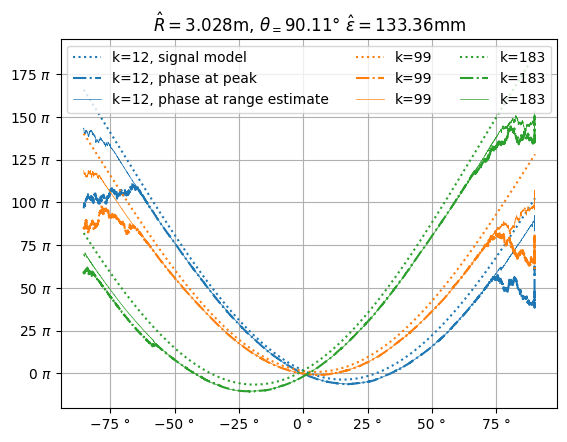

In [532]:
estimate = 2*pi*f_start * 2*r_est(R,theta0,exc, torch.tensor(angle)) / lightspeed
for k, col in zip((12,99,183), ('tab:blue', 'tab:orange', 'tab:green')):
    rangemeas = numpy.unwrap(phase[k,:])/pi
    rangemeas -= 2*int(0.5*rangemeas[l_zero])

    peakmeas = numpy.unwrap(phase_peak[k,:])/pi
    peakmeas -= 2*int(0.5*peakmeas[l_zero])

    est = numpy.unwrap(estimate[k,:])/pi
    # est-=est[0]
    est -= 2*int(0.5*est[l_zero])

    plt.plot(deg, est, ':', c=col, label=f'{k=}' + (', signal model' if k==12 else ''))
    plt.plot(deg, peakmeas, '-.', c=col, label=f'{k=}' + (', phase at peak' if k==12 else ''))
    plt.plot(deg, rangemeas, '-',c=col, linewidth=0.5, label=f'{k=}' + (', phase at range estimate' if k==12 else ''))
plt.grid()
plt.gca().xaxis.set_major_formatter(EngFormatter('°'))
plt.gca().yaxis.set_major_formatter(EngFormatter(r'$\pi$'))
plt.title(f'$\\hat R= {R:.3f}$m, $\\theta_={theta0*180/pi:.2f}$° $\\hat \\epsilon= {1000*exc:.2f}$mm')
plt.legend( loc='upper center', ncol=3)

In [492]:
K=192
def phase_estimation_mse(params, phase_peak, angle, l_zero):
    R = (params * torch.tensor([1,0,0])).sum()
    theta0 = (params * torch.tensor([0,1,0])).sum()
    exc = (params * torch.tensor([0,0,1])).sum()

    phase_est = 2*pi*f_start * 2*r_est(R,theta0,exc, torch.tensor(angle)) / lightspeed
    phase_est = phase_est - phase_est[:,l_zero,None]
    
    # with torch.no_grad():
    #     plt.plot(phase_est[0,:])
    #     plt.plot(phase_peak[0,:])
    #     plt.title(f'mse={(phase_est-phase_peak).abs().square().mean()}')
    #     plt.show()
    return (phase_peak-phase_est).square().mean()


torch.Size([192, 3000])
3.0283122062683105 90.11094526716668 13.336150348186493


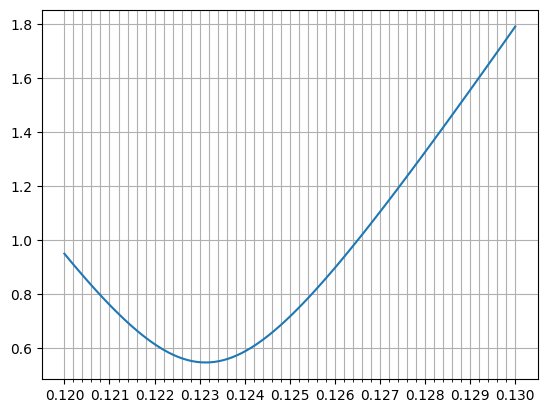

In [587]:
angle_sel = [a for a in angle if -60 < 180/pi*a-90 < 60]
deg = torch.tensor(angle_sel)*180/pi-90
l_sel = [l for l,a in enumerate(angle) if a in angle_sel]
l_zero = deg.abs().argmin()
peakmeas_unwrap = torch.tensor(numpy.unwrap(phase_peak[:,l_sel], axis=-1))
print(peakmeas_unwrap.shape)
peakmeas_unwrap = peakmeas_unwrap-peakmeas_unwrap[:,l_zero,None]

print(R, theta0*180/pi,exc*100)

test_e = torch.linspace(.12,.13,100)
phaseerror = lambda e: sqrt(phase_estimation_mse(torch.tensor([R,theta0,e]),peakmeas_unwrap,angle_sel,l_zero))/pi
plt.plot(test_e, list(map(phaseerror, test_e)))
plt.xticks(torch.linspace(.12,.13,11), minor=False)
plt.xticks(torch.linspace(.12,.13,51), minor=True)
plt.grid(which='both')
plt.show()



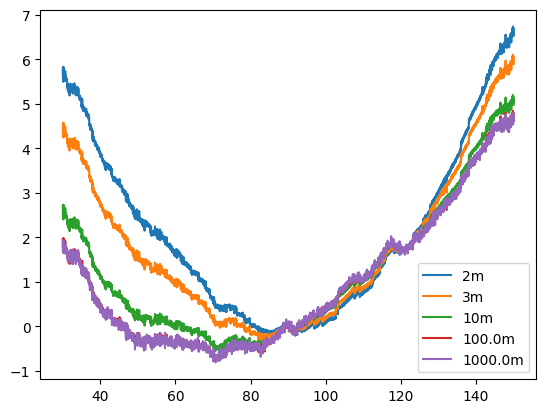

In [567]:
for r in (2,3,10,1e2,1e3):
    phase_est = 2*pi*f_start * 2*r_est(r,theta0,exc, torch.tensor(angle_sel)) / lightspeed
    phase_est = phase_est - phase_est[:,l_zero,None]
    plt.plot(deg, (phase_est[12,:]-peakmeas_unwrap[12,:])/pi, label=f'{r}m')
plt.legend()
plt.show()

In [588]:
R,theta0,exc = float(optdist),float(optangle),0.123

refldist = r_est(R,theta0,exc,torch.tensor(angle))
N_fft = 2**13
n_min = int((dist-0.5)/R_max*N)
n_max = int((dist+0.5)/R_max*N)
window = torch.hann_window(M)
window /= window.sum()

m_refl = (refldist/R_max*N_fft).long()
print(n_min,n_max)

deg = 180/pi*torch.tensor(angle)-90
l_zero = deg.abs().argmin()

phase = numpy.empty((K,L))
phase_peak = numpy.empty((K,L))
for l in range(L):
    fft = torch.fft.fft(window[:,None]*data[:,:,l], n=N_fft, dim=0)
    phase[:,l] = fft[m_refl[:,l], range(K)].angle()
    m_peak = n_min + fft[n_min:n_max,:].abs().argmax(0)
    phase_peak[:,l] = fft[m_peak,range(K)].angle()

409 573


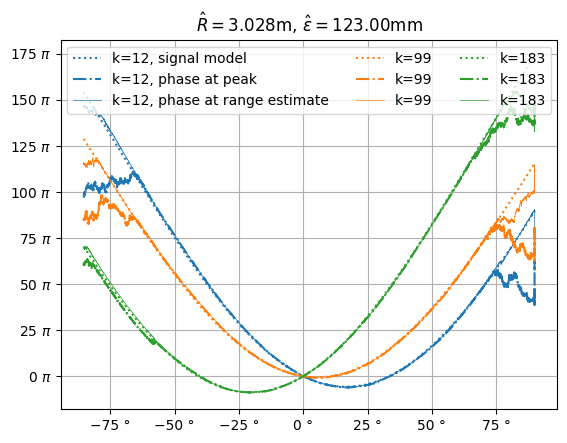

In [590]:
estimate = 2*pi*f_start * 2*r_est(R,theta0,exc, torch.tensor(angle)) / lightspeed
for k, col in zip((12,99,183), ('tab:blue', 'tab:orange', 'tab:green')):
    rangemeas = numpy.unwrap(phase[k,:])/pi
    rangemeas -= rangemeas[l_zero]

    peakmeas = numpy.unwrap(phase_peak[k,:])/pi
    peakmeas -= peakmeas[l_zero]

    est = numpy.unwrap(estimate[k,:])/pi
    # est-=est[0]
    est -= est[l_zero]

    plt.plot(deg, est, ':', c=col, label=f'{k=}' + (', signal model' if k==12 else ''))
    plt.plot(deg, peakmeas, '-.', c=col, label=f'{k=}' + (', phase at peak' if k==12 else ''))
    plt.plot(deg, rangemeas, '-',c=col, linewidth=0.5, label=f'{k=}' + (', phase at range estimate' if k==12 else ''))
plt.grid()
plt.gca().xaxis.set_major_formatter(EngFormatter('°'))
plt.gca().yaxis.set_major_formatter(EngFormatter(r'$\pi$'))
plt.title(f'$\\hat R= {R:.3f}$m, $\\hat \\epsilon= {1000*exc:.2f}$mm')
plt.legend( loc='upper center', ncol=3)

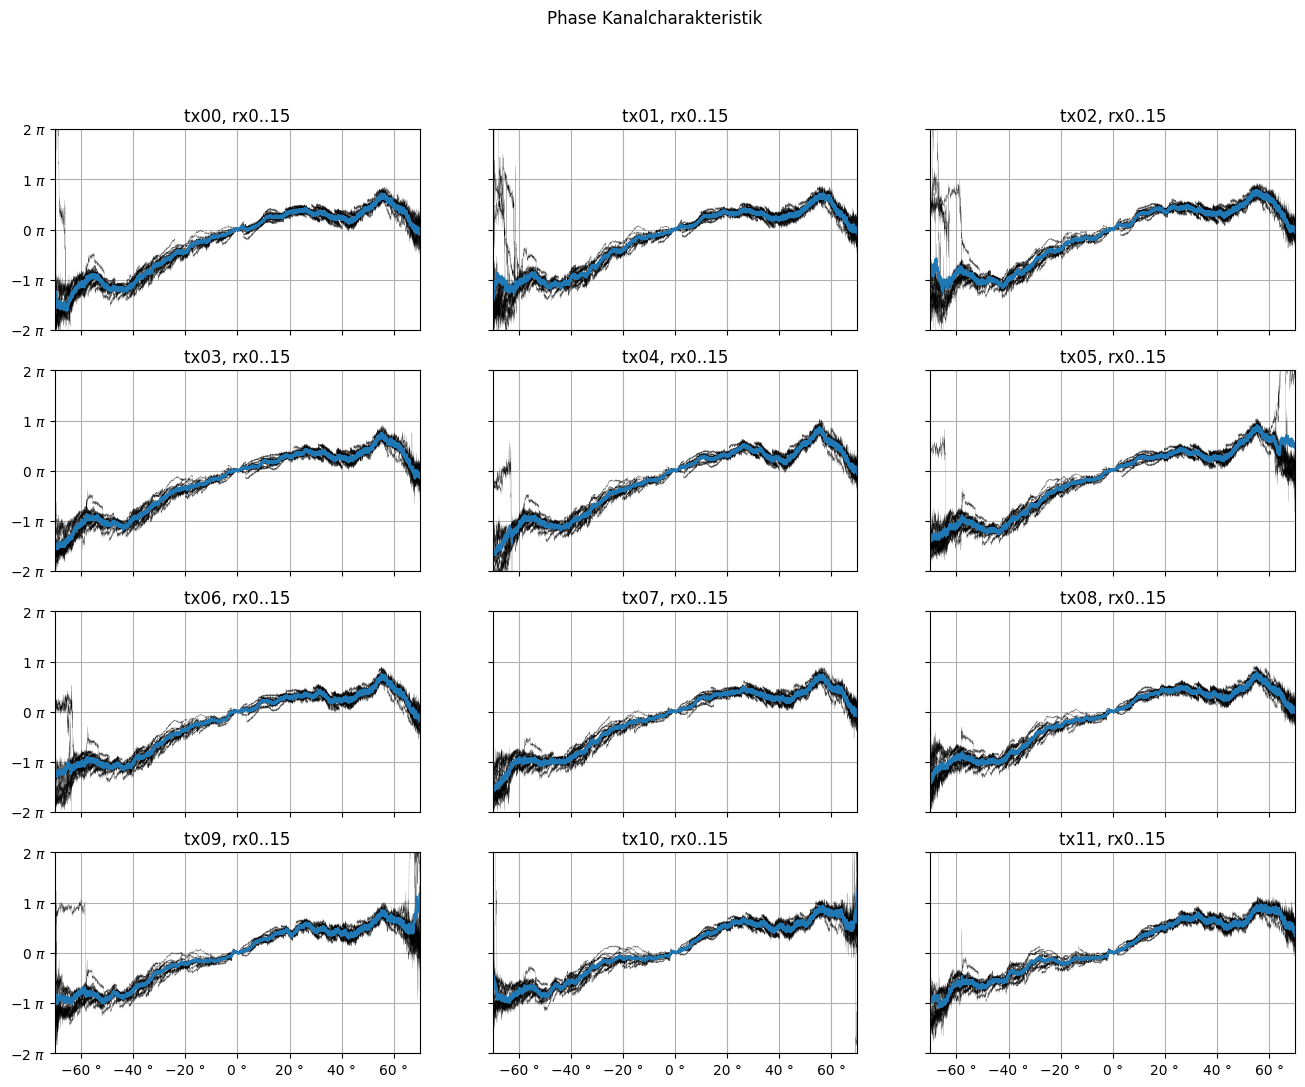

In [598]:
fig, axes = plt.subplots(4,3,sharex=True, sharey=True)
fig.set_size_inches(16,12)
fig.suptitle('Phase Kanalcharakteristik')
for n, ax in enumerate(axes.flat):
    avgdif = torch.zeros(phase.shape[1])
    for k in range(16*n,16*(n+1)):
        rangemeas = numpy.unwrap(phase[k,:])/pi
        est = numpy.unwrap(estimate[k,:])/pi
        dif = est-rangemeas
        dif -= dif[l_zero]
        ax.plot(deg, dif, 'k-', linewidth=0.1)
        avgdif += dif/16
    ax.plot(deg, avgdif)
    ax.grid()
    ax.xaxis.set_major_formatter(EngFormatter('°'))
    ax.yaxis.set_major_formatter(EngFormatter(r'$\pi$'))
    ax.set_ylim(-2,2)
    ax.set_xlim(-70,70)
    ax.set_title(f'tx{n:02d}, rx0..15')